# CnA Final Capstone Project Modelling + Feature Engineering

* Pretty simple work from the modelling aspect, just an untuned ExtraTrees Regressor and the main features did not give me many ideas for Feature engineering, nor did anny transformations or interactions work

* The Main steps, that I feel, helped me stand out from the pack was my use of the text based title feature (which mind you has a lot of scope for improvement). I simply used the functions from my [Beginner Twitter Sentiment Analysis notebook](https://www.kaggle.com/code/varunnagpalspyz/beginner-twitter-sentiment-analysis). These features are not even that good or relavant but they still helped improve my score by a lot and helped me stand out. Followed by simple function based feature extraction, I used a simple TF-IDF vectorizer for some more feature extraction. 

* Also, another key aspect is my use of my CV scores for final submission. Always remember, DONT OVERFIT to the Public LB, one should set up a proper validation scheme and rely on that. Here, you can see my 2 selected final submissions, one is based on the best public LB score and one is based on my best average CV score. The best CV score submission clearly outperforms the best public LB score one. 

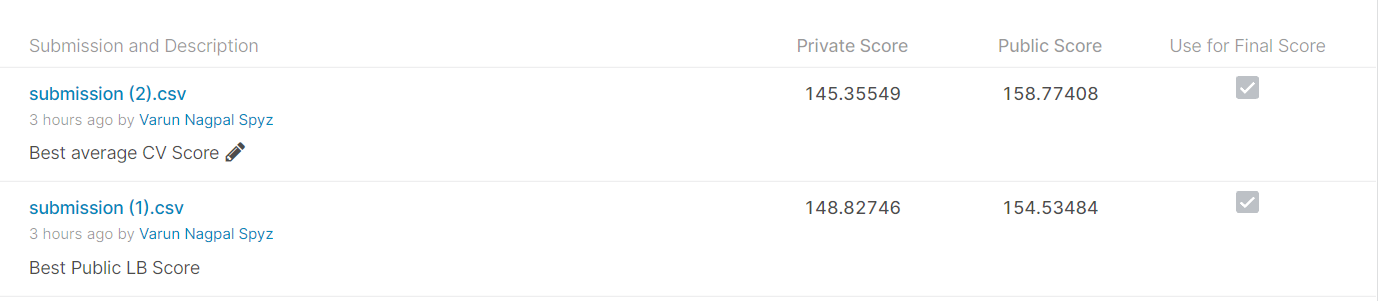

## Some Other Competition Notebooks (Mine):
(will add some more too soon)
 
* My First Hackathon (Cascade Cup organized by CnA) notebook:
[**Rank 3: Model Stacking + OP Feature eng**](https://www.kaggle.com/code/varunnagpalspyz/rank-3-model-stacking-op-feature-eng)
* My first Kaggle community competition (I overfitted the public LB badly, but I do some optuna based HyperOpt): [**Iterative Imputer + XGB + Hyp Tuning (Optuna)**](https://www.kaggle.com/code/varunnagpalspyz/iterative-imputer-xgb-hyp-tuning-optuna)
* First Baseline for TPS June'22 (very interesting competition): [**TPS June 2022 IterativeImputer (2x) Baseline**](https://www.kaggle.com/code/varunnagpalspyz/tps-june-2022-iterativeimputer-2x-baseline)

## Importing Libraries

In [1]:
#Basic Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')


from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_validate
from sklearn.ensemble import ExtraTreesRegressor 
from sklearn.metrics import mean_squared_error


import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, SnowballStemmer
from nltk import WordNetLemmatizer
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

## Loading in the Datasets

In [2]:
# the original datasets to get back the title feature I had dropped earlier
train = pd.read_csv('../input/sa2022/train.csv')
test = pd.read_csv('../input/sa2022/test.csv')

In [3]:
train.drop(train.loc[train['id'] == 9873].index,inplace = True)
train = train.reset_index(drop = True)

In [4]:
df = pd.read_csv("../input/imputed-comp-data/train.csv")
df_test = pd.read_csv("../input/imputed-comp-data/test (1).csv")
sample_submission = pd.read_csv("../input/cna-comp-test-ss/Sample__submission.csv")

In [5]:
df.head()

,id,Rating,maincateg,platform,price1,actprice1,norating1,noreviews1,star_5f,star_4f,star_3f,star_2f,star_1f,fulfilled1,kfold
0,16695.0,3.9,0.0,1.0,698.0,999.0,38.0,7.0,17.0,9.0,6.0,3.0,3.0,0.0,0.0
1,5120.0,3.8,1.0,1.0,999.0,1999.0,531.0,69.0,264.0,92.0,73.0,29.0,73.0,1.0,4.0
2,18391.0,4.4,0.0,1.0,2749.0,4999.0,17.0,4.0,11.0,3.0,2.0,1.0,0.0,1.0,3.0
3,495.0,4.2,1.0,1.0,518.0,724.0,46413.0,6229.0,1045.0,12416.0,5352.0,701.0,4595.0,1.0,0.0
4,16408.0,3.9,1.0,1.0,1379.0,2299.0,77.0,3.0,35.0,21.0,7.0,7.0,7.0,1.0,4.0


In [6]:
df['title'] = train['title']
df_test['title'] = test['title']

## Feature Engineering: The key to win hackathons

In [7]:
# Main functions from my Beginner Twitter Sentiment Analysis notebook just copy pasted
stop_words = stopwords.words('english')
def num_of_words(df):
    df['word_count'] = df['title'].apply(lambda x : len(str(x).split(" ")))
def num_of_chars(df):
    df['char_count'] = df['title'].apply(lambda x: sum(list(map(len,x.split(' ')))))
def num_of_num(df):
    df['num_count'] = df['title'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
def num_of_stop_words(df):
    df['stopwords_count'] = df['title'].apply(lambda x: len([x for x in x.split() if x in stop_words]))
def num_of_upper(df):
    df['upper_case'] = df['title'].apply(lambda x: len([x for x in x.split() if x.isupper()]))
def feature_extract(df):
    num_of_num(df)
    num_of_chars(df)
    num_of_stop_words(df)
    num_of_upper(df)
    
Word = WordNetLemmatizer()
def clean(raw):
    result = re.sub("<[a][^>]*>(.+?)</[a]>", 'Link.', raw)
    result = re.sub('&gt;', "", result) # greater than sign
    result = re.sub('&#x27;', "'", result) # apostrophe
#     result = re.sub('&quot;', '"', result) 
    result = re.sub('&#x2F;', ' ', result)
    result = re.sub('<p>', ' ', result) # paragraph tag
    result = re.sub('<i>', ' ', result) #italics tag
    result = re.sub('</i>', '', result) 
    result = re.sub('&#62;', '', result)
    result = re.sub("\n", '', result) # newline 
    return result
def remove_punct(text):
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    text = re.sub(r"[^a-zA-Z0-9?!.,]+", ' ', text)
    return text
def lower_case(df):
    df['title'] = df['title'].apply(lambda x: " ".join(x.lower() for x in x.split()))
def stop_words_remove(df):
    df['title'] = df['title'].apply(lambda x: " ".join(x for x in x.split() if x not in stop_words))
def lemmatize(df):
    df['title'] = df['title'].apply(lambda x: " ".join([Word.lemmatize(word) for word in x.split()]))
def remove_word_user(df):    
    df['title'] = df['title'].apply(lambda x: " ".join(x for x in x.split() if x != 'for'))
def remove_word_w(df):    
    df['title'] = df['title'].apply(lambda x: " ".join(x for x in x.split() if x != 'women'))
def remove_word_m(df):    
    df['title'] = df['title'].apply(lambda x: " ".join(x for x in x.split() if x != 'men'))
def remove_word_cas(df):    
    df['title'] = df['title'].apply(lambda x: " ".join(x for x in x.split() if x != 'casual'))
def remove_word_mens(df):    
    df['title'] = df['title'].apply(lambda x: " ".join(x for x in x.split() if x != 'mens'))
def remove_word_womens(df):    
    df['title'] = df['title'].apply(lambda x: " ".join(x for x in x.split() if x != 'womens'))
def remove_word_fas(df):    
    df['title'] = df['title'].apply(lambda x: " ".join(x for x in x.split() if x != 'fashionable'))
def remove_word_com(df):    
    df['title'] = df['title'].apply(lambda x: " ".join(x for x in x.split() if x != 'comfortable'))
def cleaning(df):
    df['title'] = df['title'].apply(clean)
    df['title'] = df['title'].apply(lambda x: remove_punct(x))
    lower_case(df)
    stop_words_remove(df)
    remove_word_user(df)
    remove_word_w(df)
    remove_word_m(df)
#     remove_word_mens(df)
#     remove_word_womens(df)
    remove_word_cas(df)
    lemmatize(df)

In [8]:
df['title']

0        Fashionable & Comfortable Bellies For Women  (...
1        Combo Pack of 4 Casual Shoes Sneakers For Men ...
2               Cilia Mode Leo Sneakers For Women  (White)
3                                  Men Black Sports Sandal
4                                  Men Green Sports Sandal
                               ...                        
15724                            Women Maroon Heels Sandal
15725                        Women Multicolor Flats Sandal
15726                              Women Navy Flats Sandal
15727                             Red Chief Men's Sneakers
15728                             Slip On For Men  (Brown)
Name: title, Length: 15729, dtype: object

In [9]:
# If you have any doubts regarding these functions do ask in the discussion section
feature_extract(df)
cleaning(df)
feature_extract(df_test)
cleaning(df_test)

In [10]:
#here we can see the cleaned version of the title feature
df['title']

0        fashionable comfortable belly brown
1         combo pack shoe sneaker multicolor
2              cilium mode leo sneaker white
3                         black sport sandal
4                         green sport sandal
                        ...                 
15724                     maroon heel sandal
15725                 multicolor flat sandal
15726                       navy flat sandal
15727                  red chief men sneaker
15728                             slip brown
Name: title, Length: 15729, dtype: object

In [11]:
#redundant feature which i ended up not using
def noun_extraction(sentence):
    nouns = []
    for word,pos in nltk.pos_tag(nltk.word_tokenize(str(sentence))):
        if (pos == 'NN' or pos == 'NNP' or pos == 'NNS' or pos == 'NNPS'):
            nouns.append(word)
    return ' '.join([str(elem) for elem in nouns])

df['noun'] = df['title'].apply(noun_extraction)
df_test['noun'] = df_test['title'].apply(noun_extraction)

In [12]:
df['noun']

0                                    
1        pack shoe sneaker multicolor
2             cilium mode leo sneaker
3                        sport sandal
4                        sport sandal
                     ...             
15724              maroon heel sandal
15725               multicolor sandal
15726                          sandal
15727                     men sneaker
15728                      slip brown
Name: noun, Length: 15729, dtype: object

In [13]:
# Basic and most probably useless Feature Engineering
df['another1']=(5*df['star_5f']+4*df['star_4f']+3*df['star_3f']+2*df['star_2f']+df['star_1f'])/(1+df['star_5f']+df['star_4f']+df['star_3f']+df['star_2f']+df['star_1f'])
df_test['another1']=(5*df_test['star_5f']+4*df_test['star_4f']+3*df_test['star_3f']+2*df_test['star_2f']+df_test['star_1f'])/(1+df_test['star_5f']+df_test['star_4f']+df_test['star_3f']+df_test['star_2f']+df_test['star_1f'])

df['total_activity'] = df['norating1'] + df['noreviews1']+df['star_5f']+df['star_4f']+df['star_3f']+df['star_2f']+df['star_1f']
df_test['total_activity'] = df_test['norating1'] + df_test['noreviews1']+df_test['star_5f']+df_test['star_4f']+df_test['star_3f']+df_test['star_2f']+df_test['star_1f']

binary_feat = ['fulfilled1','maincateg','platform']
df["counts"] = df[binary_feat].sum(axis=1)
df_test["counts"] = df_test[binary_feat].sum(axis=1)

df['weird'] = df['Rating']*(7+df['fulfilled1'])
df_test['weird'] = df_test['Rating']*(7+df_test['fulfilled1'])

## TF-IDF Vectorizer + Simple ExtraTreesRegressor Model

In [14]:
useful_features = [c for c in df.columns if c not in ("id","price1", "kfold",'Offer %')]
id_test = df_test['id']
df_test = df_test[useful_features]

In [15]:
x = df.drop(['id','price1','kfold'],axis = 'columns')
y = df['price1']
xtest = df_test

# vect_word = TfidfVectorizer(max_features=1000, analyzer='word', stop_words='english', ngram_range=(1,3))
vect_word = TfidfVectorizer(analyzer='word', stop_words='english')
tfidf_title = vect_word.fit_transform(x["title"].tolist())
tfidf_title_test = vect_word.transform(xtest["title"].tolist())
x.drop(['title','noun'],axis = 'columns',inplace = True)
xtest.drop(['title','noun'],axis = 'columns',inplace = True)
x = pd.DataFrame(pd.concat([x,pd.DataFrame.sparse.from_spmatrix(tfidf_title)],axis = 'columns'))
xtest = pd.DataFrame(pd.concat([xtest,pd.DataFrame.sparse.from_spmatrix(tfidf_title_test)],axis = 'columns'))

In [16]:
model = ExtraTreesRegressor(random_state = 42)
model.fit(x, y)
test_preds = model.predict(xtest)

In [17]:
cv_results = cross_validate(model, x, y, cv=5,scoring=('neg_root_mean_squared_error'),return_train_score=False)
cv_results

{'fit_time': array([105.42862487, 112.63789988, 107.59093261, 111.89066195,
        104.63408494]),
 'score_time': array([0.33521032, 0.34445286, 0.34174085, 0.33941245, 0.32914495]),
 'test_score': array([-152.50720706, -181.42771232, -166.25539903, -170.7831074 ,
        -156.00717053])}

In [18]:
abs(cv_results['test_score'].mean())

165.3961192683605

In [19]:
# Some results from training different params of the TF-IDF vectorizer
#500
# {'fit_time': array([69.55976152, 67.61298251, 69.44387007, 68.18652964, 69.75602651]),
#  'score_time': array([0.2142868 , 0.20959592, 0.21368289, 0.21365952, 0.24082041]),
#  'test_score': array([-158.66817026, -183.42429241, -166.58823273, -170.86648855,
#         -159.96784428])}

#1000 (best lb score)
# {'fit_time': array([112.09689379, 114.44258952, 115.63454747, 113.56576586,
#         115.33543873]),
#  'score_time': array([0.24004245, 0.24272132, 0.25215101, 0.2660706 , 0.25051212]),
#  'test_score': array([-157.83806922, -183.49165728, -167.35737716, -170.28711395,
#         -157.14293003])}

#1000 (new best lb score)
# {'fit_time': array([112.17561531, 111.81409812, 112.97700548, 109.97892737,
#         113.56415248]),
#  'score_time': array([0.21085095, 0.2260015 , 0.21736646, 0.20981693, 0.22178292]),
#  'test_score': array([-158.44045526, -180.50342408, -164.9133526 , -171.29568787,
#         -158.8418692 ])}

#none (best cv score)
# {'fit_time': array([ 99.31165314,  99.16946173,  99.94600701,  97.73249483,
#         100.82774591]),
#  'score_time': array([0.30185771, 0.3207438 , 0.31988502, 0.30441189, 0.33367586]),
#  'test_score': array([-153.02689974, -179.72747505, -164.18247413, -174.73193535,
#         -157.68519441])}

## Submission

In [20]:
df_test['final_preds'] = np.round(test_preds)
df_test['id'] = id_test
sample_submission = pd.read_csv("../input/cna-comp-test-ss/Sample__submission.csv")
sample_submission = sample_submission.merge(df_test[['final_preds','id']],on = 'id',how = 'left')
sample_submission = sample_submission.drop('price1',axis = 'columns')
sample_submission.columns = ['id','price1']
sample_submission.to_csv("submission.csv", index=False)
sample_submission

,id,price1
0,19841,778.0
1,19157,729.0
2,19445,199.0
3,8046,401.0
4,4571,1399.0
...,...,...
5239,14488,795.0
5240,6273,1619.0
5241,12429,475.0
5242,8847,474.0
